In [1]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *
print(Config.data_path())

C:\Users\bokhy\.fastai\data


In [26]:
pd.set_option('display.max_columns', None)

In [27]:
PATH=Config().data_path()/Path('rossmann/')
print(PATH)

C:\Users\bokhy\.fastai\data\rossmann


In [28]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']
tables = [pd.read_csv(PATH/f'{fname}.csv', low_memory=False) for fname in table_names]
train, store, store_states, state_names, googletrend, weather, test = tables
len(train),len(test)

(1017209, 41088)

In [29]:
# turn state Holidays to booleans
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

In [30]:
# Define Join dataframe fundtino
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [31]:
# Join weather/state names
weather = join_df(weather, state_names, "file", "StateName")
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,78,1028,1022,1014,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225,NordrheinWestfalen,NW
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,77,1035,1030,1026,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240,NordrheinWestfalen,NW
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,87,1036,1035,1034,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263,NordrheinWestfalen,NW
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,87,1035,1034,1033,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268,NordrheinWestfalen,NW


In [32]:
# Using googletrends, extracting dates and state names from the given data and adding those columns.
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

### MUST STEP IN TIME SERIES ###

In [33]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [34]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [35]:
# The Google trends data has a special category for the whole of the Germany 
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

#### outer join all of our data into a single dataframe

In [36]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [37]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [38]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [39]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [40]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [41]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [42]:
joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,Dayofweek_DE,Dayofyear_DE,Is_month_end_DE,Is_month_start_DE,Is_quarter_end_DE,Is_quarter_start_DE,Is_year_end_DE,Is_year_start_DE,Elapsed_DE,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,23,16,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,19,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,21,13,6,10,7,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,19,14,9,9,7,4,94,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,20,15,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen


#### Filling Missing Values

In [43]:
# Here, we chose a random number that doesn't otherwise appear in the data
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [44]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [45]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [46]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5], dtype=int64)

In [47]:
# Same for promo dates
from isoweek import Week
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [48]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [49]:
joined.to_pickle(PATH/'joined')
joined_test.to_pickle(PATH/'joined_test')

In [51]:
joined.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,Dayofweek_DE,Dayofyear_DE,Is_month_end_DE,Is_month_start_DE,Is_quarter_end_DE,Is_quarter_start_DE,Is_year_end_DE,Is_year_start_DE,Elapsed_DE,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks
1017204,1111,2,2013-01-01,0,0,0,0,True,1,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400,a,a,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2013-01-06 - 2013-01-12,63,Rossmann_DE,2013-01-06 - 2013-01-12,62,2013-01-06,None,1,6,6,6,False,False,False,False,False,False,1357430400,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,2014-06-15,0,0,2013-07-29,0,0
1017205,1112,2,2013-01-01,0,0,0,0,True,1,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400,c,c,1880.0,4,2006,0,1,1900,NaN,NW,Rossmann_DE_NW,2013-01-06 - 2013-01-12,63,Rossmann_DE,2013-01-06 - 2013-01-12,62,2013-01-06,None,1,6,6,6,False,False,False,False,False,False,1357430400,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,2006-04-15,2453,24,1900-01-01,0,0
1017206,1113,2,2013-01-01,0,0,0,0,True,1,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400,a,c,9260.0,1,1900,0,1,1900,NaN,SH,Rossmann_DE_SH,2013-01-06 - 2013-01-12,72,Rossmann_DE,2013-01-06 - 2013-01-12,62,2013-01-06,None,1,6,6,6,False,False,False,False,False,False,1357430400,8,7,6,7,7,5,100,95,93,1002,1000,999,10.0,8.0,5.0,23,16,NaN,0.00,6.0,Rain,251,SchleswigHolstein,1900-01-15,0,0,1900-01-01,0,0
1017207,1114,2,2013-01-01,0,0,0,0,True,1,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400,a,c,870.0,1,1900,0,1,1900,NaN,HH,Rossmann_DE_HH,2013-01-06 - 2013-01-12,63,Rossmann_DE,2013-01-06 - 2013-01-12,62,2013-01-06,None,1,6,6,6,False,False,False,False,False,False,1357430400,8,6,4,8,6,3,100,92,70,1007,1001,997,31.0,11.0,6.0,40,23,63.0,6.10,6.0,Rain,234,Hamburg,1900-01-15,0,0,1900-01-01,0,0
1017208,1115,2,2013-01-01,0,0,0,0,True,1,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400,d,c,5350.0,1,1900,1,22,2012,"Mar,Jun,Sept,Dec",HE,Rossmann_DE_HE,2013-01-06 - 2013-01-12,73,Rossmann_DE,2013-01-06 - 2013-01-12,62,2013-01-06,None,1,6,6,6,False,False,False,False,False,False,1357430400,8,6,3,6,3,1,93,80,59,1015,1008,1006,31.0,12.0,10.0,23,14,39.0,2.03,6.0,Rain,206,Hessen,1900-01-15,0,0,2012-05-28,218,25


#### Adding "Durations" columns to help predict

In [27]:
# Given a particular field fld to monitor, this function will start tracking time since the last occurrence of that field
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [28]:
# Applying the above eplased to below 5 columns.
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [29]:
df = train[columns].append(test[columns])

In [30]:
# We'll first sort by Store, then Date, and then call add_elapsed('SchoolHoliday', 'After'): 
# This will apply to each row with School Holiday:

# A applied to every row of the dataframe in order of store and date
# Will add to the dataframe the days since seeing a School Holiday
# If we sort in the other direction, this will count the days until another holiday.

In [31]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [32]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [33]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [34]:
# We're going to set the active index to Date.
df = df.set_index("Date")

In [35]:
# Then set null values from elapsed field calculations to 0.
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

In [36]:
# Here we're sorting by date (sort_index()) and counting the number of events of interest (sum()) defined in columns in the following week (rolling()), grouped by Store (groupby()). 
# We do the same in the opposite direction.
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [37]:
# drop the Store indices grouped together in the window functio
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [38]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [39]:
df.reset_index(inplace=True)

In [40]:
# Now merge these values onto the df.

In [41]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [42]:
df.drop(columns,1,inplace=True)
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


In [43]:
df.to_pickle(PATH/'df')

In [44]:
df["Date"] = pd.to_datetime(df.Date)

In [45]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [46]:
# Load previously saved pandas
joined = pd.read_pickle(PATH/'joined')
joined_test = pd.read_pickle(PATH/f'joined_test')

In [47]:
# Join again with the added columns above
joined = join_df(joined, df, ['Store', 'Date'])
joined = joined[joined.Sales!=0]
joined_test = join_df(joined_test, df, ['Store', 'Date'])

#### Save dataframe

In [48]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [49]:
joined.to_pickle(PATH/'train_clean')
joined_test.to_pickle(PATH/'test_clean')

# Time Series Analysis

In [50]:
%reload_ext autoreload
%autoreload 2

In [51]:
from fastai.tabular import *

In [52]:
# Load the preprocessed training data
PATH=Config().data_path()/Path('rossmann/')
train_df = pd.read_pickle(PATH/'train_clean')
test_df = pd.read_pickle(PATH/'test_clean')

In [53]:
pd.set_option('display.max_columns', None)

In [54]:
train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,Dayofweek_DE,Dayofyear_DE,Is_month_end_DE,Is_month_start_DE,Is_quarter_end_DE,Is_quarter_start_DE,Is_year_end_DE,Is_year_start_DE,Elapsed_DE,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,a,1270.0,9,2008,0,1,1900,NaN,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,23,16,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen,2008-09-15,2510,24,1900-01-01,0,0,0,0,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,19,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen,2007-11-15,2815,24,2010-03-29,1950,25,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,21,13,6,10,7,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen,2006-12-15,3150,24,2011-04-04,1579,25,0,0,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,c,620.0,9,2009,0,1,1900,NaN,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,19,14,9,9,7,4,94,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin,2009-09-15,2145,24,1900-01-01,0,0,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,29910.0,4,2015,0,1,1900,NaN,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,20,15,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen,2015-04-15,107,3,1900-01-01,0,0,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [55]:
n = len(train_df); n

844338

In [56]:
procs=[FillMissing, Categorify, Normalize]

In [58]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 
            'CompetitionMonthsOpen', 'Promo2Weeks', 'StoreType', 'Assortment',
            'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State',
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 
            'StateHoliday_bw','SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC',
             'Min_TemperatureC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
             'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend',
             'trend_DE','AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 
             'SchoolHoliday']

In [59]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()
# or
# train_df.copy()

In [60]:
df.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date
0,1,5,2015,7,31,False,24,0,c,a,NaN,2008,1900,HE,31,Fog,5.0,5.0,0.0,0.0,7.0,5.0,1270.0,23,16,8,98,54,18,24,11,1.0,85,83,57,0,1,1,5263,2015-07-31
1,2,5,2015,7,31,False,24,25,a,a,"Jan,Apr,Jul,Oct",2007,2010,TH,31,Fog,1.0,5.0,0.0,0.0,1.0,5.0,570.0,19,13,7,100,62,25,14,11,4.0,80,83,67,0,1,1,6064,2015-07-31
2,3,5,2015,7,31,False,24,25,a,a,"Jan,Apr,Jul,Oct",2006,2011,NW,31,Fog,5.0,5.0,0.0,0.0,5.0,5.0,14130.0,21,13,6,100,61,24,14,5,2.0,86,83,57,0,1,1,8314,2015-07-31
3,4,5,2015,7,31,False,24,0,c,c,NaN,2009,1900,BE,31,NaN,1.0,5.0,0.0,0.0,1.0,5.0,620.0,19,14,9,94,61,30,23,16,6.0,74,83,67,0,1,1,13995,2015-07-31
4,5,5,2015,7,31,False,3,0,a,a,NaN,2015,1900,SN,31,NaN,1.0,5.0,0.0,0.0,1.0,5.0,29910.0,20,15,10,82,55,26,14,11,4.0,82,83,57,0,1,1,4822,2015-07-31


In [61]:
# For valid_inx in Time Series,
# we want to have the valid set's time is almost at the end of the train data
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [62]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut
valid_idx = range(cut)
print(valid_idx)

range(0, 41395)


In [63]:
# Create DataBunch
# anytime you're trying to predict something like a population or a dollar amount of sales, always use log = True (RMSPE becomes root mean squared error)
data = (TabularList.from_df(df, path=PATH, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True) 
                   .databunch())

In [64]:
data.show_batch()

Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,CompetitionDistance_na,CloudCover_na,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,target
52,1,2013,10,14,False,0,25,d,c,"Jan,Apr,Jul,Oct",2014,2010,BY,42,Fog,0.0,4.0,0.0,0.0,0.0,0.0,False,True,-0.6409,0.0130,-0.3775,-0.7169,0.8653,1.0387,0.6318,-1.2877,-1.1514,0.2552,-0.4997,-0.2678,-0.8593,0.6303,-0.8994,-0.4796,8.736168
897,5,2014,8,22,False,24,25,c,c,"Feb,May,Aug,Nov",2007,2013,RP,34,#na#,1.0,5.0,0.0,0.0,5.0,5.0,False,False,-0.2769,0.9752,0.6092,0.3871,-0.0532,-1.3378,-1.2014,-0.5109,-0.6483,1.4864,-1.2248,0.0564,0.8151,-0.1089,1.1119,2.0852,8.105005
480,5,2014,7,25,False,20,0,a,a,#na#,2012,1900,BE,30,Rain-Thunderstorm,4.0,0.0,0.0,0.0,5.0,5.0,False,False,-0.6601,1.0954,1.4551,1.8065,0.0780,0.5788,0.3263,0.1549,-0.1452,0.8708,0.5878,1.2454,0.2464,-0.9714,-0.8994,2.0852,8.2380085
940,1,2013,8,5,False,10,0,d,c,#na#,2012,1900,SN,32,Fog,0.0,4.0,0.0,0.0,5.0,5.0,False,False,0.1306,1.5765,1.7370,1.8065,0.8653,0.5021,-0.8959,-0.7328,-0.6483,-0.3604,0.8597,0.2726,0.9099,-0.6325,-0.8994,2.0852,8.838262
59,1,2014,12,15,False,24,25,a,c,"Jan,Apr,Jul,Oct",2007,2011,TH,51,Fog-Rain,5.0,1.0,0.0,0.0,0.0,0.0,False,False,-0.3346,-0.8288,-1.0824,-1.3478,0.8653,1.1154,0.7336,1.0426,0.1902,0.2552,0.5878,1.4616,0.2149,0.8768,1.1119,-0.4796,9.271247


In [65]:
# Create a Learner

# y values are going to be taken the log first, we need to make sure that the y_range we want is also the log
# multiply it by a little bit (1.2) to give the opportunity to give exact data (like last time)
# Then our y_range will be from zero to a bit more than the maximum --> Make sure to convert to tensor!

max_log_y = np.log(np.max(train_df['Sales'])*1.2) 
# max_log_y = np.max(train_df['Sales'])*1.2
y_range = torch.tensor([0, max_log_y], device=defaults.device)
y_range

tensor([ 0.0000, 10.8170], device='cuda:0')

In [66]:
# PS is drop-out
# Weight matrix is going to have to go from a 1000 activation input to a 500 activation output, 
# which means it's going to have to be 500,000 elements in that weight matrix. 
# That's an awful lot for a data set with only a few hundred thousand rows. 
# So this is going to overfit, and we need to make sure it doesn't. so we have to regularize using dropout

learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics= exp_rmspe)
#learn = tabular_learner(data, layers=[200,100],
 #                       y_range=y_range, metrics= exp_rmspe)

In [67]:
learn.model

# Each of those embedding matrices tells you the number of levels for each input (the first number) . 
# You can match these with your list cat_vars. So the first one will be Store, so that's not surprising there are 1,116 stores. 
# Then the second number, of course, is the size of the embedding. That's a number that you get to choose.

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [68]:
len(data.train_ds.cat_names)

24

In [69]:
len(data.train_ds.cont_names)

16

In [70]:
learn.loss_func

FlattenedLoss of MSELoss()

In [71]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.31E-01


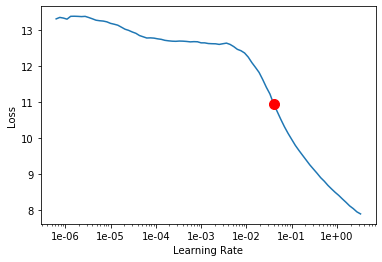

In [72]:
learn.recorder.plot(suggestion=True)

In [73]:
learn.fit_one_cycle(4, 3.31e-1, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,5.026899,4.371504,8.157589,08:13
1,4.829176,32.693489,6.568133,08:02
2,4.527025,4.369411,8.152955,08:02
3,0.017375,0.016482,0.122707,08:29


In [89]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.019551,0.019766,0.122604,08:06
1,0.018592,0.027189,0.141221,08:05
2,0.015882,0.016882,0.120636,08:05
3,0.013791,0.012318,0.111508,08:03
4,0.011095,0.011376,0.102316,08:01


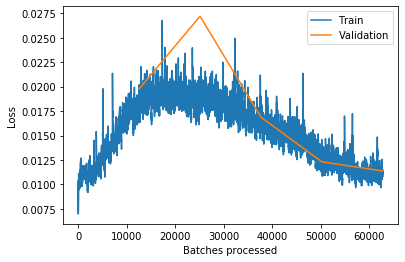

In [90]:
learn.recorder.plot_losses()

In [77]:
# Save it for fine tuning
learn.save('time_series')

In [81]:
learn.load('time_series');
# or 
# learn.export()
# learn = load_learner(df_test)

In [84]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3), pct_start=0.8)

ZeroDivisionError: division by zero

In [86]:
# And we can predict on a row of dataframe that has the right cat_names and cont_names.
learn.predict(test_df.iloc[300])

(FloatItem [8.941299], tensor([8.9413]), tensor([8.9413]))